#### Bibliotecas e Base de Dados

In [294]:
import pandas as pd
import os
import math
from statsmodels.tsa.seasonal import STL
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt
# Carregar o dataframe tratado
df = pd.read_csv("base_tratada_lingualab2.csv")


In [295]:
df

ID_Cliente    Motivo     Education        Cidade  Renda_anual  \
0              0    Viagem     Gradua√ß√£o     S√£o Paulo      58138.0   
1              1  Trabalho     Gradua√ß√£o       Taubat√©      46344.0   
2              3    Viagem     Gradua√ß√£o     S√£o Paulo          NaN   
3              4  Trabalho     Doutorado     S√£o Paulo      58293.0   
4              5  Trabalho      Mestrado     S√£o Paulo          NaN   
...          ...       ...           ...           ...          ...   
2060        1484    Viagem  Ensino M√©dio     S√£o Paulo      75484.0   
2061        1512   Estudos     Gradua√ß√£o       Taubat√©      73538.0   
2062        1929  Trabalho      Mestrado     S√£o Paulo      62694.0   
2063        2046  Trabalho     Gradua√ß√£o     S√£o Paulo      53154.0   
2064        2070   Estudos     Gradua√ß√£o  S√£o Bernardo      54591.0   

                  Aulas  NPS  Num_Aulas  Ano_de_nascimento  Banheiros_na_casa  \
0                Ingles    4         19               1983                  3   
1              Espanhol    4         10               1980                  4   
2              Espanhol    4         22               2010                  1   
3                Ingles    3          8               2007                  3   
4              Espanhol    3          9               1993                  4   
...                 ...  ...        ...                ...                ...   
2060             Ingles    2         44               2002                  5   
2061  Espanhol e Ingles    5         45               1991                  5   
2062             Ingles    2         45               1991                  3   
2063             Ingles    3         45               1985                  2   
2064             Ingles    4         44               1975                  3   

      Quartos_na_casa  motivo_na  renda_na Quartos_Banheiros faixa_idade  
0                   4      False     False             4Q_3B       1980s  
1                   3      False     False             3Q_4B       1980s  
2                   1      False      True             1Q_1B       2010s  
3                   4      False     False             4Q_3B       2000s  
4                   4      False      True             4Q_4B       1990s  
...               ...        ...       ...               ...         ...  
2060                6      False     False             6Q_5B       2000s  
2061                5      False     False             5Q_5B       1990s  
2062                4      False     False             4Q_3B       1990s  
2063                4      False     False             4Q_2B       1980s  
2064                4      False     False             4Q_3B       <1980  

[2065 rows x 15 columns]

In [297]:
df.describe()

ID_Cliente    Renda_anual          NPS    Num_Aulas  \
count  2065.000000    1754.000000  2065.000000  2065.000000   
mean   1126.299274   50759.482055     2.783535    15.688136   
std     647.446233   20577.427127     1.183756    10.765136   
min       0.000000    1730.000000     1.000000     1.000000   
25%     562.000000   34388.000000     2.000000     8.000000   
50%    1131.000000   50556.000000     3.000000    13.000000   
75%    1691.000000   67441.750000     4.000000    22.000000   
max    2239.000000  105471.000000     5.000000    45.000000   

       Ano_de_nascimento  Banheiros_na_casa  Quartos_na_casa  
count        2065.000000        2065.000000      2065.000000  
mean         1995.672155           2.939952         3.399031  
std            11.360825           1.409504         1.721276  
min          1967.000000           1.000000         1.000000  
25%          1987.000000           2.000000         2.000000  
50%          1997.000000           3.000000         3.000000  
75%          2004.000000           4.000000         5.000000  
max          2022.000000           5.000000         6.000000

#### PERFIL E SEGMENTA√á√ÉO DE CLIENTES

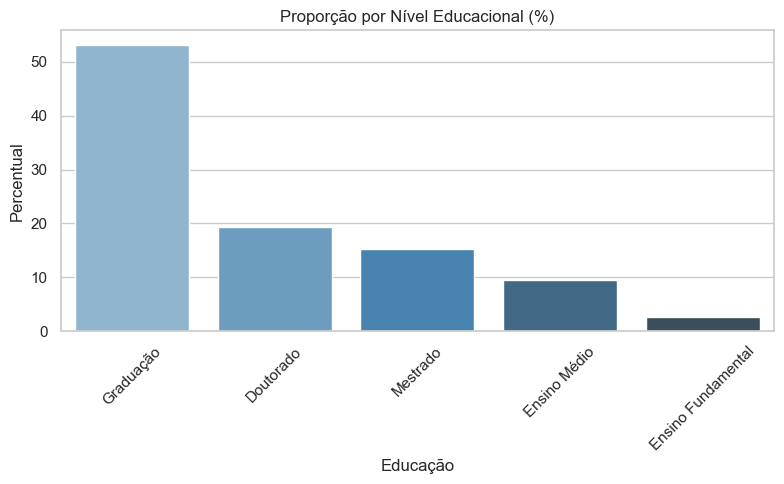

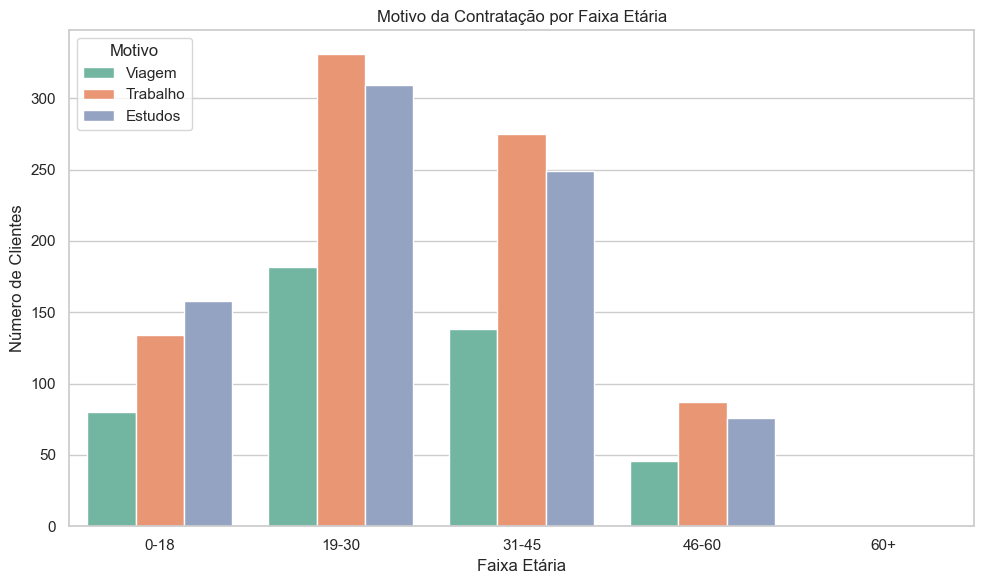

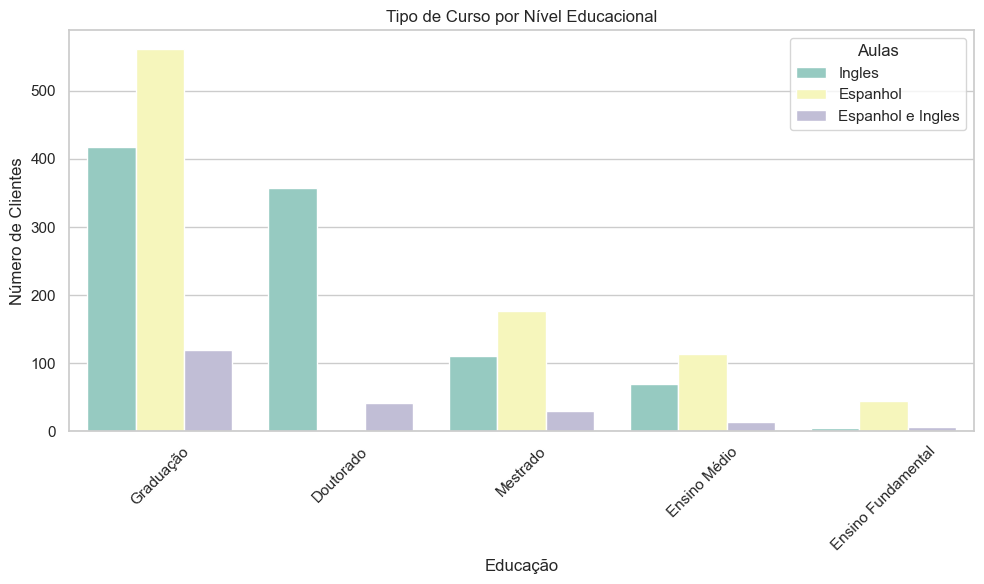

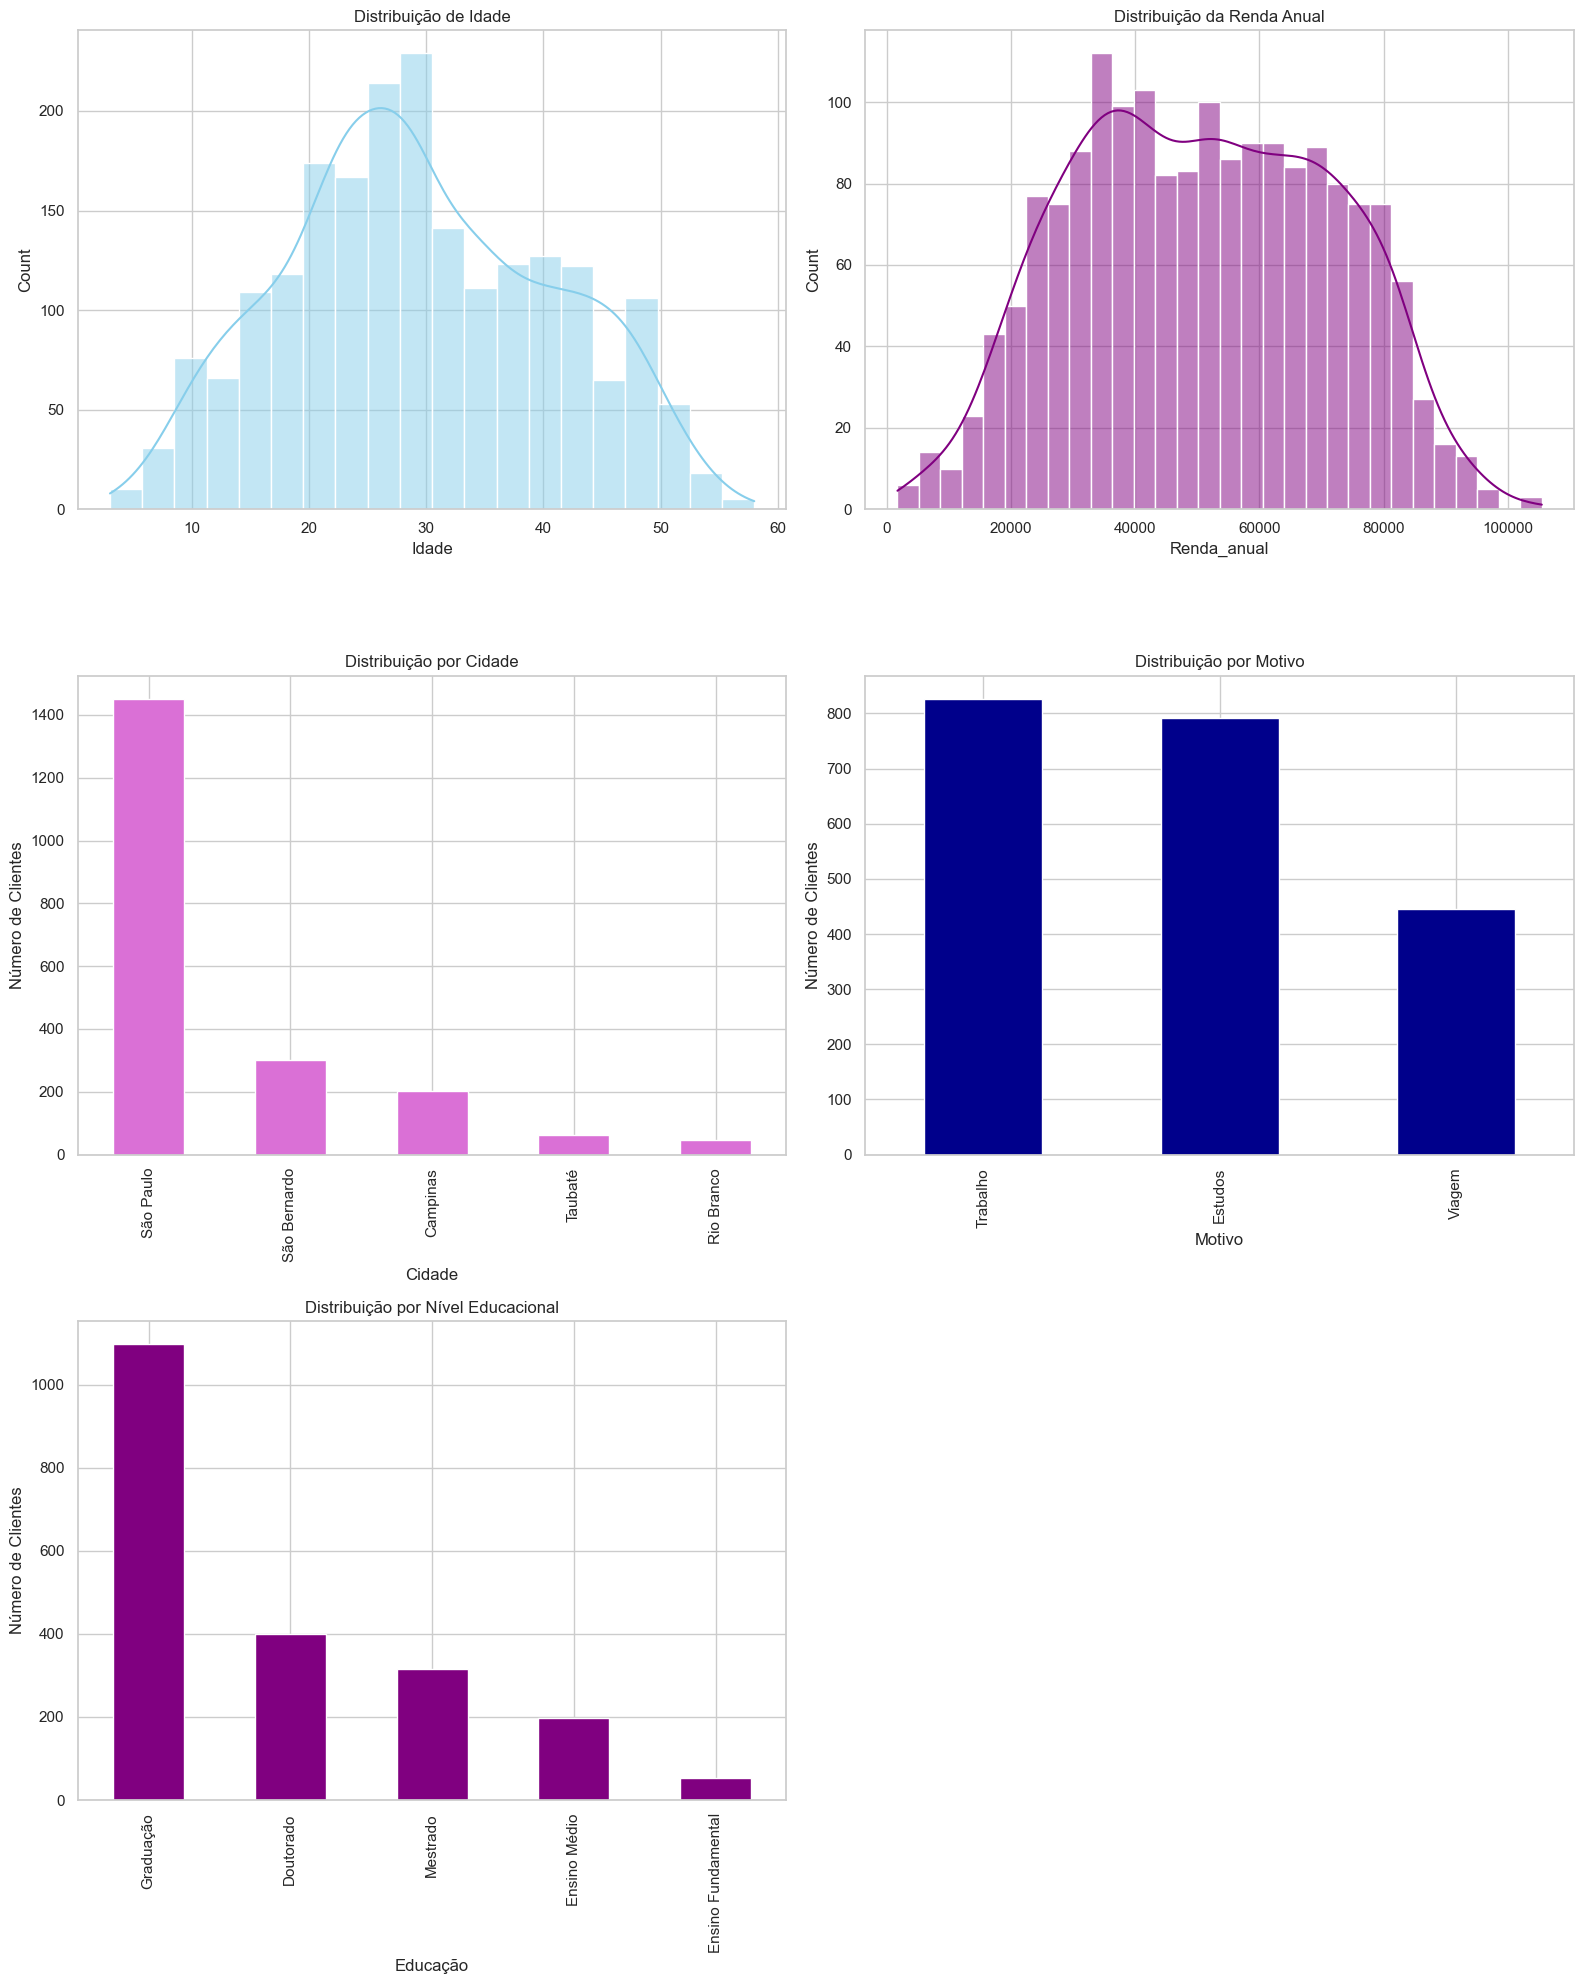


üìä Tabela para PowerPoint:

      Cidade  Clientes   Motivo  Clientes           Educa√ß√£o  Clientes
   S√£o Paulo      1452 Trabalho     827.0          Gradua√ß√£o      1098
S√£o Bernardo       301  Estudos     792.0          Doutorado       399
    Campinas       203   Viagem     446.0           Mestrado       316
     Taubat√©        62      NaN       NaN       Ensino M√©dio       198
  Rio Branco        47      NaN       NaN Ensino Fundamental        54


In [298]:
# Perfil sociodemogr√°fico dos clientes
# N√≠vel educacional m√©dio por cluster
# Distribui√ß√£o geogr√°fica da base
# Poder aquisitivo por regi√£o

# Vari√°veis para cruzar:
# Cidade √ó Renda_anual
# Education √ó Ano_de_nascimento (gerar idade)
# Renda_anual √ó Banheiros_na_casa e Quartos_na_casa
# Cidade √ó Motivo
# Education √ó Motivo
# Motivo √ó Aulas


# Adicionando coluna de idade
current_year = datetime.now().year
df["Idade"] = current_year - df["Ano_de_nascimento"]

# Faixa et√°ria
df["Faixa_Etaria"] = pd.cut(df["Idade"], bins=[0, 18, 30, 45, 60, 100],
                            labels=["0-18", "19-30", "31-45", "46-60", "60+"])

# Propor√ß√£o por n√≠vel educacional
plt.figure(figsize=(8, 5))
edu_counts = df["Education"].value_counts(normalize=True).sort_values(ascending=False) * 100
sns.barplot(x=edu_counts.index, y=edu_counts.values, palette="Blues_d")
plt.title("Propor√ß√£o por N√≠vel Educacional (%)")
plt.ylabel("Percentual")
plt.xlabel("Educa√ß√£o")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Motivo da contrata√ß√£o por faixa et√°ria
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Faixa_Etaria", hue="Motivo", palette="Set2")
plt.title("Motivo da Contrata√ß√£o por Faixa Et√°ria")
plt.xlabel("Faixa Et√°ria")
plt.ylabel("N√∫mero de Clientes")
plt.tight_layout()
plt.show()

# Tipo de curso por perfil educacional
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Education", hue="Aulas", palette="Set3", order=edu_counts.index)
plt.title("Tipo de Curso por N√≠vel Educacional")
plt.xlabel("Educa√ß√£o")
plt.ylabel("N√∫mero de Clientes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



df["Idade"] = 2025 - df["Ano_de_nascimento"]
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

# 1. Distribui√ß√£o da idade
plt.subplot(3, 2, 1)
sns.histplot(df["Idade"], bins=20, kde=True, color='skyblue')
plt.title("Distribui√ß√£o de Idade")

# 2. Distribui√ß√£o da Renda Anual
plt.subplot(3, 2, 2)
sns.histplot(df["Renda_anual"], bins=30, kde=True, color='purple')
plt.title("Distribui√ß√£o da Renda Anual")

# 3. Distribui√ß√£o por Cidade
plt.subplot(3, 2, 3)
df["Cidade"].value_counts().plot(kind='bar', color='orchid')
plt.title("Distribui√ß√£o por Cidade")
plt.xlabel("Cidade")
plt.ylabel("N√∫mero de Clientes")

# 4. Distribui√ß√£o por Motivo
plt.subplot(3, 2, 4)
df["Motivo"].value_counts().plot(kind='bar', color='darkblue')
plt.title("Distribui√ß√£o por Motivo")
plt.xlabel("Motivo")
plt.ylabel("N√∫mero de Clientes")

# 5. Distribui√ß√£o por N√≠vel Educacional
plt.subplot(3, 2, 5)
df["Education"].value_counts().plot(kind='bar', color='purple')
plt.title("Distribui√ß√£o por N√≠vel Educacional")
plt.xlabel("Educa√ß√£o")
plt.ylabel("N√∫mero de Clientes")

plt.tight_layout()
plt.show()

import pandas as pd

# Contagens
cidade_counts = df["Cidade"].value_counts().reset_index()
cidade_counts.columns = ["Cidade", "Clientes"]

motivo_counts = df["Motivo"].value_counts().reset_index()
motivo_counts.columns = ["Motivo", "Clientes"]

educ_counts = df["Education"].value_counts().reset_index()
educ_counts.columns = ["Educa√ß√£o", "Clientes"]

# Garantir mesmo n√∫mero de linhas (preencher com NaN)
max_len = max(len(cidade_counts), len(motivo_counts), len(educ_counts))
cidade_counts = cidade_counts.reindex(range(max_len)).reset_index(drop=True)
motivo_counts = motivo_counts.reindex(range(max_len)).reset_index(drop=True)
educ_counts = educ_counts.reindex(range(max_len)).reset_index(drop=True)

# Juntar as tr√™s colunas em uma √∫nica tabela
df_ppt = pd.concat([cidade_counts, motivo_counts, educ_counts], axis=1)

# Exibir de forma limpa para copiar e colar no PowerPoint
print("\nüìä Tabela para PowerPoint:\n")
print(df_ppt.to_string(index=False))


clusteriza√ß√£o com o algoritmo K-Means.

In [299]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

# 1. Calcular idade
df['Idade'] = datetime.now().year - df['Ano_de_nascimento']

# 2. Criar vari√°veis ordinais
education_order = {
    'Ensino Fundamental': 1,
    'Ensino M√©dio': 2,
    'Gradua√ß√£o': 3,
    'Mestrado': 4,
    'Doutorado': 5
}
df['Edu_Ordinal'] = df['Education'].map(education_order)

motivo_order = {
    'Trabalho': 2,
    'Estudos': 3,
    'Viagem': 1
}
df['Motivo_Ordinal'] = df['Motivo'].map(motivo_order)

aulas_order = {
    'Ingles': 4,
    'Espanhol': 3,
    'Espanhol e Ingles': 2,
    'Mandarim': 1
}
df['Aulas_Ordinal'] = df['Aulas'].map(aulas_order)

# 3. Selecionar vari√°veis para o clustering
cluster_cols = [
    'Idade', 'Renda_anual', 'Num_Aulas', 'NPS',
    'Edu_Ordinal', 'Motivo_Ordinal', 'Aulas_Ordinal'
]
cluster_df = df[cluster_cols].copy()

# 4. Imputar valores faltantes com a mediana
cluster_df = cluster_df.fillna(cluster_df.median(numeric_only=True))

# 5. Padronizar os dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

# 6. Aplicar KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# 7. Resumo por cluster
cluster_summary = df.groupby('Cluster').agg({
    'Edu_Ordinal': 'mean',
    'Motivo_Ordinal': 'mean',
    'Aulas_Ordinal': 'mean',
    'Idade': 'mean',
    'Renda_anual': 'mean',
    'Num_Aulas': 'mean',
    'NPS': 'mean',
    'ID_Cliente': 'count'
}).rename(columns={'ID_Cliente': 'Qtd_Clientes'}).round(2)

print("\nResumo por Cluster:")
print(cluster_summary)





Resumo por Cluster:
         Edu_Ordinal  Motivo_Ordinal  Aulas_Ordinal  Idade  Renda_anual  \
Cluster                                                                   
0               3.46            2.29           2.35  32.65     56642.60   
1               2.68            3.00           3.11  25.62     38480.45   
2               3.00            2.19           3.99  32.45     68979.73   
3               3.08            1.50           3.09  26.41     39606.52   
4               4.86            2.12           4.00  31.45     54770.18   

         Num_Aulas   NPS  Qtd_Clientes  
Cluster                                 
0            17.90  3.39           275  
1            10.22  2.24           410  
2            24.69  3.26           420  
3             9.74  2.28           545  
4            18.33  3.09           415  


Valida√ß√µes da clusterizacao 

A in√©rcia mede qu√£o compactos os clusters est√£o. O gr√°fico mostra a in√©rcia para diferentes valores de k (n√∫mero de clusters). Quando a redu√ß√£o da in√©rcia come√ßa a diminuir (o ‚Äúcotovelo‚Äù), esse √© o n√∫mero ideal de clusters.

Coeficiente de Silhueta (Silhouette Score)
Esse valor varia entre -1 e 1:
Pr√≥ximo de 1: pontos est√£o bem dentro dos seus clusters;
Pr√≥ximo de 0: pontos est√£o entre clusters;
Negativo: pontos podem estar em clusters errados.

Visualiza√ß√£o em 2D com PCA
Reduzimos a base para 2 dimens√µes com PCA e plotamos os clusters. Se os grupos forem bem separados visualmente, isso valida a segmenta√ß√£o.

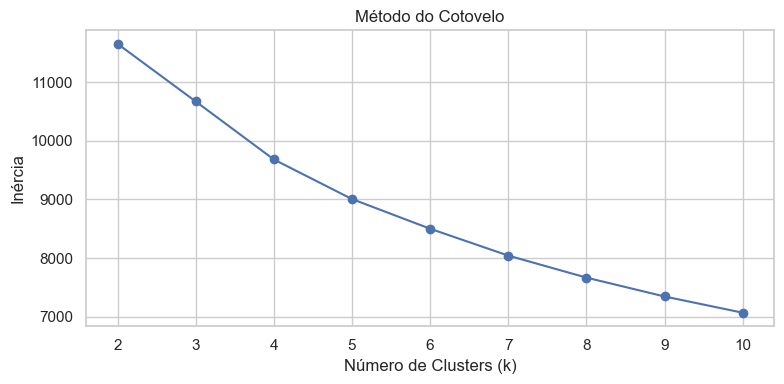


üîç Silhouette Score para k=5: 0.1573


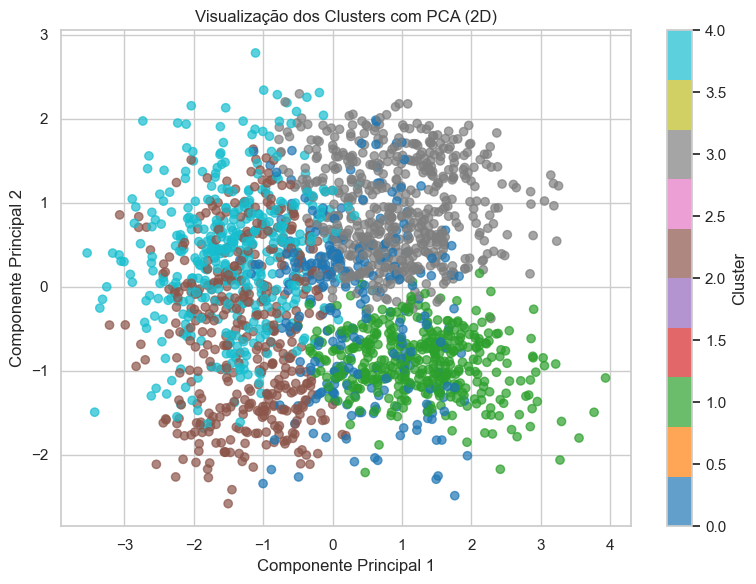

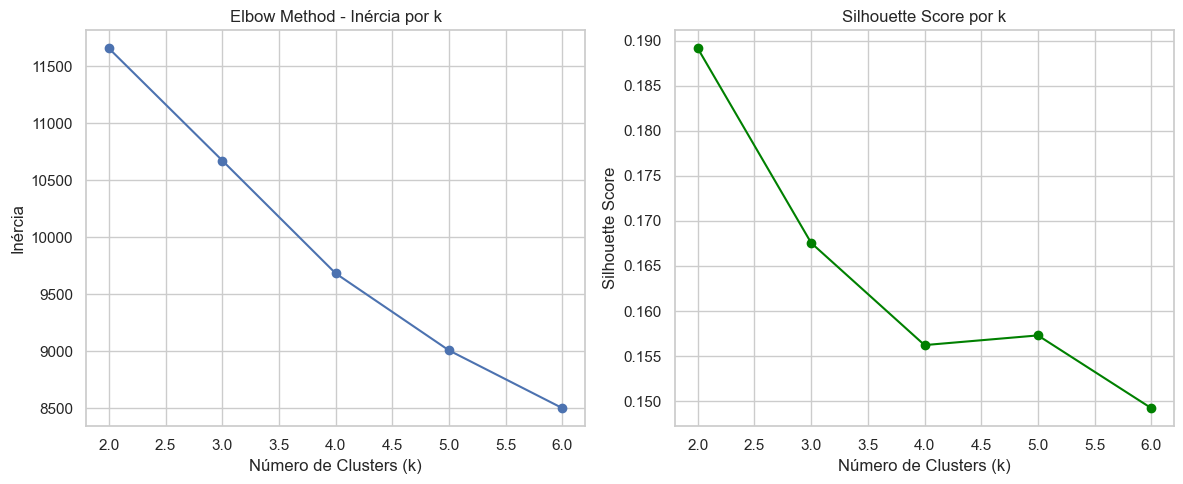

In [300]:


import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Vari√°veis selecionadas (com ordinais)
X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Edu_Ordinal', 'Motivo_Ordinal', 'Aulas_Ordinal']]

# Preencher valores ausentes com mediana
X = X.fillna(X.median(numeric_only=True))

# Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Gr√°fico do Cotovelo (k de 2 a 10)
inertias = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertias, marker='o')
plt.title('M√©todo do Cotovelo')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('In√©rcia')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Silhouette Score para k=3
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
sil_score = silhouette_score(X_scaled, clusters)
print(f"\nüîç Silhouette Score para k={k}: {sil_score:.4f}")

# 3. Visualiza√ß√£o PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title('Visualiza√ß√£o dos Clusters com PCA (2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# 4. Elbow + Silhouette Score em conjunto (k de 2 a 6)
inertias = []
silhouettes = []
ks = range(2, 7)

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Gerar gr√°ficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Elbow
axs[0].plot(ks, inertias, marker='o')
axs[0].set_title('Elbow Method - In√©rcia por k')
axs[0].set_xlabel('N√∫mero de Clusters (k)')
axs[0].set_ylabel('In√©rcia')

# Silhouette
axs[1].plot(ks, silhouettes, marker='o', color='green')
axs[1].set_title('Silhouette Score por k')
axs[1].set_xlabel('N√∫mero de Clusters (k)')
axs[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()







In [301]:

# M√©dia das vari√°veis por cluster
cluster_avg = df.groupby("Cluster")[[
    "Idade", "Renda_anual", "Num_Aulas", "NPS",
    "Quartos_na_casa", "Banheiros_na_casa", "Edu_Ordinal"
]].mean().round(2)

cluster_avg["Qtd_Clientes"] = df["Cluster"].value_counts().sort_index()

# Tabelas cruzadas
cluster_cidade = pd.crosstab(df["Cluster"], df["Cidade"])
cluster_motivo = pd.crosstab(df["Cluster"], df["Motivo"])
cluster_educ = pd.crosstab(df["Cluster"], df["Education"])

print("\nCluster √ó Motivo:")
print(cluster_motivo)

print("\nCluster √ó Educa√ß√£o:")
print(cluster_educ)




Cluster √ó Motivo:
Motivo   Estudos  Trabalho  Viagem
Cluster                           
0            109       136      30
1            410         0       0
2            172       156      92
3              0       274     271
4            101       261      53

Cluster √ó Educa√ß√£o:
Education  Doutorado  Ensino Fundamental  Ensino M√©dio  Gradua√ß√£o  Mestrado
Cluster                                                                    
0                 38                   2            12        156        67
1                  1                  34            81        279        15
2                  0                   1            48        322        49
3                  2                  17            57        341       128
4                358                   0             0          0        57


Com k=4
Separava mais nuances (como renda alta com baixa aula vs. muita aula com mesma renda), mas isso sacrificava a separa√ß√£o geral entre grupos (Silhouette menor, PCA mais embaralhado).

#### Clusterizacao 2

In [302]:
# # Calcular a idade
# df['Idade'] = datetime.now().year - df['Ano_de_nascimento']

# # Converter 'Education' para formato ordinal
# education_order = {
#     'Ensino Fundamental': 1,
#     'Ensino M√©dio': 2,
#     'Gradua√ß√£o': 3,
#     'Mestrado': 4,
#     'Doutorado': 5
# }
# df['Edu_Ordinal'] = df['Education'].map(education_order)

# # Selecionar vari√°veis para clusteriza√ß√£o
# cluster_df = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']].copy()

# # Padronizar os dados
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(cluster_df)

# # Aplicar KMeans (4 clusters como exemplo)
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# df['Cluster'] = kmeans.fit_predict(scaled_data)

# # Gerar resumo por cluster
# cluster_summary = df.groupby('Cluster').agg({
#     'Edu_Ordinal': 'mean',
#     'Idade': 'mean',
#     'Renda_anual': 'mean',
#     'Num_Aulas': 'mean',
#     'NPS': 'mean',
#     'ID_Cliente': 'count'
# }).rename(columns={'ID_Cliente': 'Qtd_Clientes'})

# # Exibir a tabela resumo
# print("\nResumo por Cluster:")
# print(cluster_summary.round(2))



In [303]:
# # Selecionar e padronizar vari√°veis
# X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 1. Gr√°fico do Cotovelo
# inertias = []
# for k in range(2, 11):
#     km = KMeans(n_clusters=k, random_state=42, n_init=10)
#     km.fit(X_scaled)
#     inertias.append(km.inertia_)

# plt.figure(figsize=(8, 4))
# plt.plot(range(2, 11), inertias, marker='o')
# plt.title('M√©todo do Cotovelo')
# plt.xlabel('N√∫mero de Clusters (k)')
# plt.ylabel('In√©rcia')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 2. Silhouette Score para o melhor k (ex: 4)
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# clusters = kmeans.fit_predict(X_scaled)
# sil_score = silhouette_score(X_scaled, clusters)
# print(f"\nüîç Silhouette Score para k=3: {sil_score:.4f}")

# # 3. PCA para visualiza√ß√£o
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
# plt.title('Visualiza√ß√£o dos Clusters com PCA (2D)')
# plt.xlabel('Componente Principal 1')
# plt.ylabel('Componente Principal 2')
# plt.colorbar(scatter, label='Cluster')
# plt.tight_layout()
# plt.show()


# # Elbow + Silhouette Score (at√© k=6)
# inertias = []
# silhouettes = []
# for k in range(2, 7):
#     model = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = model.fit_predict(scaled_data)
#     inertias.append(model.inertia_)
#     silhouettes.append(silhouette_score(scaled_data, labels))

# # Gerar visualiza√ß√µes
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # Elbow
# axs[0].plot(range(2, 7), inertias, marker='o')
# axs[0].set_title('Elbow Method - In√©rcia por k')
# axs[0].set_xlabel('N√∫mero de Clusters (k)')
# axs[0].set_ylabel('In√©rcia')

# # Silhouette
# axs[1].plot(range(2, 7), silhouettes, marker='o', color='green')
# axs[1].set_title('Silhouette Score por k')
# axs[1].set_xlabel('N√∫mero de Clusters (k)')
# axs[1].set_ylabel('Silhouette Score')

# plt.tight_layout()
# plt.show()

#### Clusteriza√ß√£o por DB Scan 

In [304]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA


# # Sele√ß√£o e padroniza√ß√£o
# X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicar DBSCAN
# dbscan = DBSCAN(eps=1.3, min_samples=15)
# labels = dbscan.fit_predict(X_scaled)

# # Adicionar os r√≥tulos ao DataFrame
# df['DBSCAN_Cluster'] = labels

# # N√∫mero de clusters encontrados (excluindo ru√≠do)
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise = list(labels).count(-1)
# print(f"Clusters encontrados: {n_clusters}")
# print(f"Outliers detectados: {n_noise}")

# # Visualiza√ß√£o com PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
# plt.title('Clusters via DBSCAN (com outliers em -1)')
# plt.xlabel('Componente Principal 1')
# plt.ylabel('Componente Principal 2')
# plt.colorbar(scatter, label='Cluster')
# plt.tight_layout()
# plt.show()


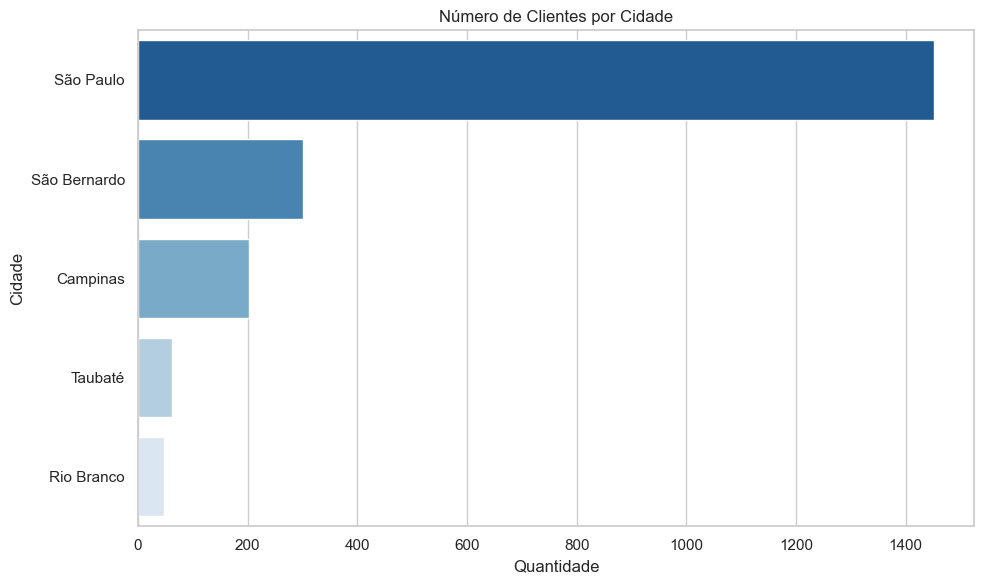

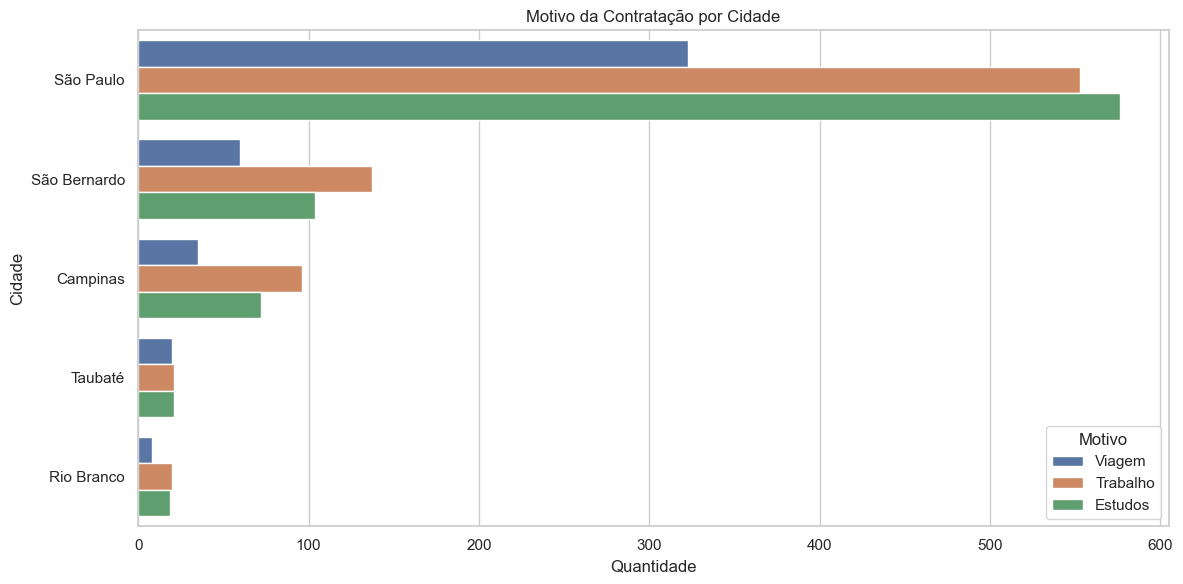

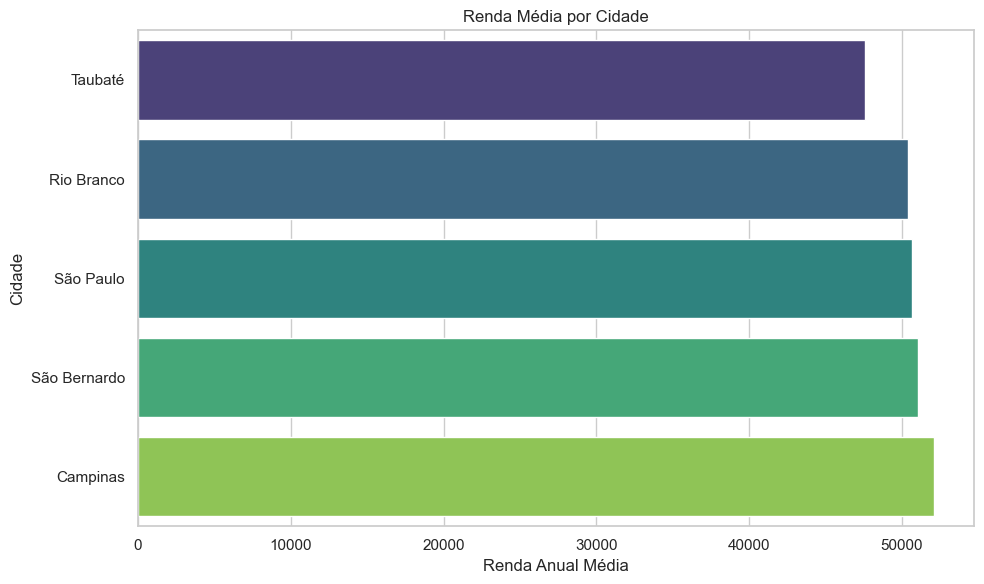

In [305]:
# Gr√°fico 1: Contagem absoluta de clientes por cidade
plt.figure(figsize=(10, 6))
cidade_order = df['Cidade'].value_counts().index
sns.countplot(data=df, y='Cidade', order=cidade_order, palette='Blues_r')
plt.title('N√∫mero de Clientes por Cidade')
plt.xlabel('Quantidade')
plt.ylabel('Cidade')
plt.tight_layout()
plt.show()

# Gr√°fico 2: Distribui√ß√£o por Motivo dentro de cada cidade (proporcional)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Cidade', hue='Motivo', order=cidade_order)
plt.title('Motivo da Contrata√ß√£o por Cidade')
plt.xlabel('Quantidade')
plt.ylabel('Cidade')
plt.legend(title='Motivo')
plt.tight_layout()
plt.show()

# Gr√°fico 3: Renda m√©dia por cidade
renda_cidade = df.groupby('Cidade')['Renda_anual'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=renda_cidade.values, y=renda_cidade.index, palette='viridis')
plt.title('Renda M√©dia por Cidade')
plt.xlabel('Renda Anual M√©dia')
plt.ylabel('Cidade')
plt.tight_layout()
plt.show()

cruzar cluster com cidade?

In [306]:
# T√≥pico 4 ‚Äî Poder Aquisitivo por Regi√£o (utilizando cidades como proxy de regi√£o)

# Calcular estat√≠sticas de renda por cidade
renda_stats = df.groupby('Cidade')['Renda_anual'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)
renda_stats = renda_stats.rename(columns={
    'mean': 'Renda M√©dia',
    'median': 'Renda Mediana',
    'count': 'Qtd Clientes',
    'std': 'Desvio Padr√£o'
})

## Reexibir a tabela de forma compat√≠vel com o ambiente do usu√°rio

renda_stats.reset_index(inplace=True)
renda_stats


Cidade   Renda M√©dia  Renda Mediana  Qtd Clientes  Desvio Padr√£o
0      Campinas  52113.668571        49767.0           175   20315.497048
1  S√£o Bernardo  51086.050411        51250.0           253   21304.222860
2     S√£o Paulo  50650.209195        50447.0          1231   20474.540807
3    Rio Branco  50425.103692        46610.0            41   20479.084612
4       Taubat√©  47585.777778        47207.0            54   20729.198663

#### Conclusoes 

A base de clientes √© heterog√™nea, mas segment√°vel

A an√°lise mostrou que, apesar da diversidade em idade, renda, escolaridade e objetivos, a base se organiza em tr√™s clusters bem definidos, validados estatisticamente (Silhouette Score) e visualmente (PCA).

O Elbow Method indicou que k=3 √© o ponto √≥timo, e o Silhouette Score (~0.27) mostra que h√° coes√£o nos grupos formados.

A visualiza√ß√£o PCA confirmou separa√ß√£o espacial clara entre os clusters, legitimando a aplica√ß√£o de marketing segmentado.

Geografia importa ‚Äî S√£o Paulo lidera com folga
Todos os clusters s√£o altamente concentrados em S√£o Paulo, mas o Cluster 2 tem a maior presen√ßa proporcional.
Cidades como Campinas, S√£o Bernardo e Taubat√© t√™m import√¢ncia secund√°ria, mas relevante para a√ß√µes regionais.

Estrat√©gias regionais devem priorizar S√£o Paulo como epicentro de campanhas, com microsegmenta√ß√µes locais nos demais polos urbanos.

#### PADR√ïES DE CONSUMO

Valores √∫nicos em df['Aulas']: ['Ingles' 'Espanhol' 'Espanhol E Ingles']


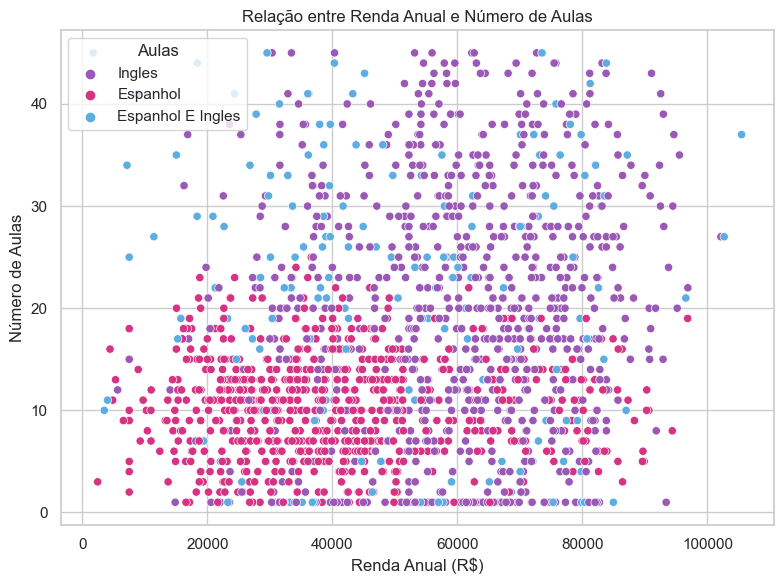

Faixas et√°rias que mais consomem aulas (m√©dia):
faixa_idade
<1980    17.172249
1990s    16.394904
1980s    16.292683
2000s    15.054770
2010s    13.134921
Name: Num_Aulas, dtype: float64 

N√≠vel educacional que mais consome aulas (m√©dia):
Education
Doutorado             18.804511
Mestrado              15.202532
Gradua√ß√£o             15.026412
Ensino M√©dio          14.530303
Ensino Fundamental    13.203704
Name: Num_Aulas, dtype: float64 

Motivo mais associado ao consumo de aulas (m√©dia):
Motivo
Trabalho    16.226119
Estudos     15.648990
Viagem      14.760090
Name: Num_Aulas, dtype: float64 

Tipos de aula mais contratados (frequ√™ncia):
Aulas
Ingles               960
Espanhol             895
Espanhol E Ingles    210
Name: count, dtype: int64 

Idade m√©dia dos maiores consumidores (top 25% em n√∫mero de aulas): 31.27 anos


In [311]:



# 1. Limpeza da vari√°vel 'Aulas' (remover espa√ßos, capitaliza√ß√£o)
df["Aulas"] = df["Aulas"].str.strip().str.title()  # 'mandarim' vira 'Mandarim'

# 2. Verificar se todos os tipos aparecem
print("Valores √∫nicos em df['Aulas']:", df["Aulas"].unique())

# 3. Garantir que n√£o h√° NaN nas vari√°veis usadas no scatterplot
df_plot = df.dropna(subset=["Renda_anual", "Num_Aulas", "Aulas"]).copy()

# 4. Plot com cores fixas para garantir Mandarim na legenda
palette = {
    "Ingles": "royalblue",
    "Espanhol": "darkorange",
    "Espanhol E Ingles": "seagreen",
    "Mandarim": "crimson"
}

# 1. Quem mais compra aulas? (Top perfis por m√©dia de aulas)
mais_aulas_por_faixa_etaria = df.groupby("faixa_idade")["Num_Aulas"].mean().sort_values(ascending=False)
mais_aulas_por_educacao = df.groupby("Education")["Num_Aulas"].mean().sort_values(ascending=False)
mais_aulas_por_motivo = df.groupby("Motivo")["Num_Aulas"].mean().sort_values(ascending=False)

# 2. Tipos de aula mais contratados
tipos_de_aula = df["Aulas"].value_counts()

# 3. Rela√ß√£o entre Renda e N√∫mero de Aulas

palette_roxa_contraste_melhorada = [
    "#9b59b6",  # Roxo cl√°ssico (lavanda escuro)
    "#d63384",  # Rosa magenta vibrante (combina com roxo)
    "#5dade2",  # Azul petr√≥leo claro (contraste e sofistica√ß√£o)
]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot, 
    x="Renda_anual", 
    y="Num_Aulas", 
    hue="Aulas", 
    palette=palette_roxa_contraste_melhorada
)
plt.title("Rela√ß√£o entre Renda Anual e N√∫mero de Aulas")
plt.xlabel("Renda Anual (R$)")
plt.ylabel("N√∫mero de Aulas")
plt.legend(title="Aulas")
plt.tight_layout()
plt.show()



# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x="Renda_anual", y="Num_Aulas", hue="Aulas")
# plt.title("Rela√ß√£o entre Renda Anual e N√∫mero de Aulas")
# plt.xlabel("Renda Anual (R$)")
# plt.ylabel("N√∫mero de Aulas")
# plt.show()

# 4. Idade m√©dia dos maiores consumidores (top 25% em n√∫mero de aulas)
limite_top_consumidores = df["Num_Aulas"].quantile(0.75)
top_consumidores = df[df["Num_Aulas"] >= limite_top_consumidores]
idade_media_top_consumidores = top_consumidores["Idade"].mean()

# Exibir os resultados anal√≠ticos
print("Faixas et√°rias que mais consomem aulas (m√©dia):")
print(mais_aulas_por_faixa_etaria, "\n")

print("N√≠vel educacional que mais consome aulas (m√©dia):")
print(mais_aulas_por_educacao, "\n")

print("Motivo mais associado ao consumo de aulas (m√©dia):")
print(mais_aulas_por_motivo, "\n")

print("Tipos de aula mais contratados (frequ√™ncia):")
print(tipos_de_aula, "\n")

print(f"Idade m√©dia dos maiores consumidores (top 25% em n√∫mero de aulas): {idade_media_top_consumidores:.2f} anos")


O n√∫mero de aulas contratadas est√° fortemente associado √† maturidade e ao n√≠vel educacional dos usu√°rios: indiv√≠duos com maior escolaridade ‚Äî especialmente aqueles com mestrado ou doutorado ‚Äî e com idade acima dos 30 anos s√£o os que mais consomem. A motiva√ß√£o profissional (‚Äútrabalho‚Äù) aparece como o principal impulsionador do engajamento, superando motivos como ‚Äúestudos‚Äù ou ‚Äúviagem‚Äù. Al√©m disso, o ingl√™s √© o idioma mais demandado, embora o espanhol tamb√©m tenha relev√¢ncia significativa, apontando para oportunidades em pacotes combinados. Apesar da renda influenciar o consumo, a rela√ß√£o n√£o √© perfeitamente linear, o que indica que fatores como tempo dispon√≠vel e motiva√ß√£o s√£o igualmente decisivos. Esses achados sustentam decis√µes estrat√©gicas voltadas √† personaliza√ß√£o de campanhas, √† diversifica√ß√£o de produtos e √† segmenta√ß√£o com base no ciclo de vida e objetivo do cliente.

#### SATISFA√á√ÉO E NPS

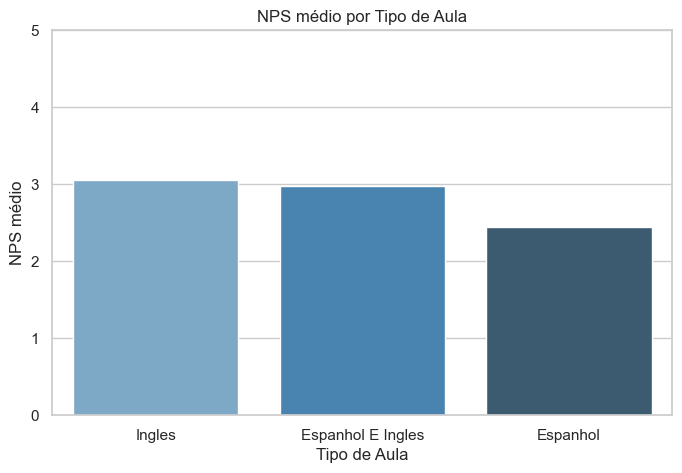

Perfil m√©dio dos clientes mais satisfeitos (NPS ‚â• m√©dia):
Idade             29.51
Renda_anual    53042.64
Num_Aulas         16.89
Edu_Ordinal        3.48
dtype: float64 

Correla√ß√£o entre vari√°veis e NPS:
NPS            1.000000
Num_Aulas      0.141190
Renda_anual    0.140796
Idade          0.035289
Name: NPS, dtype: float64 

NPS m√©dio por Cidade:
Cidade
Campinas        2.891626
S√£o Bernardo    2.813953
S√£o Paulo       2.775482
Taubat√©         2.661290
Rio Branco      2.531915
Name: NPS, dtype: float64 

NPS m√©dio por Tipo de Aula:
Aulas
Ingles               3.059375
Espanhol E Ingles    2.976190
Espanhol             2.442458
Name: NPS, dtype: float64 

NPS m√©dio por N√≠vel Educacional:
Education
Doutorado             3.060150
Mestrado              2.775316
Ensino M√©dio          2.752525
Gradua√ß√£o             2.709472
Ensino Fundamental    2.407407
Name: NPS, dtype: float64 



In [ ]:


# 1. Perfil dos clientes mais satisfeitos (alto NPS)
# Considerar clientes com NPS acima da m√©dia
nps_medio = df["NPS"].mean()
clientes_satisfeitos = df[df["NPS"] >= nps_medio]

perfil_satisfeitos = clientes_satisfeitos[[
    "Idade", "Renda_anual", "Num_Aulas", "Edu_Ordinal"
]].mean().round(2)

# 2. Correla√ß√£o entre consumo e satisfa√ß√£o
correlacoes = df[["Num_Aulas", "Renda_anual", "Idade", "NPS"]].corr()["NPS"].sort_values(ascending=False)

# 3. NPS por cidade, tipo de aula e perfil (educa√ß√£o)
nps_por_cidade = df.groupby("Cidade")["NPS"].mean().sort_values(ascending=False)
nps_por_aula = df.groupby("Aulas")["NPS"].mean().sort_values(ascending=False)
nps_por_educacao = df.groupby("Education")["NPS"].mean().sort_values(ascending=False)

# Visualiza√ß√£o: NPS por tipo de aula
plt.figure(figsize=(8, 5))
sns.barplot(x=nps_por_aula.index, y=nps_por_aula.values, palette="Blues_d")
plt.title("NPS m√©dio por Tipo de Aula")
plt.ylabel("NPS m√©dio")
plt.xlabel("Tipo de Aula")
plt.ylim(0, 5)
plt.show()

# Resultados
print("Perfil m√©dio dos clientes mais satisfeitos (NPS ‚â• m√©dia):")
print(perfil_satisfeitos, "\n")

print("Correla√ß√£o entre vari√°veis e NPS:")
print(correlacoes, "\n")

print("NPS m√©dio por Cidade:")
print(nps_por_cidade, "\n")

print("NPS m√©dio por Tipo de Aula:")
print(nps_por_aula, "\n")

print("NPS m√©dio por N√≠vel Educacional:")
print(nps_por_educacao, "\n")


An√°lise dos dados de satisfa√ß√£o (NPS) revela que os clientes mais satisfeitos da LinguaLab s√£o, em m√©dia, adultos jovens com cerca de 29 anos, renda anual em torno de R$ 53 mil, e engajamento acima da m√©dia (cerca de 18 aulas realizadas). Al√©m disso, esse grupo apresenta um n√≠vel educacional intermedi√°rio a avan√ßado, com m√©dia pr√≥xima de gradua√ß√£o. A correla√ß√£o entre vari√°veis mostra que tanto a quantidade de aulas consumidas quanto a renda possuem leve rela√ß√£o positiva com o NPS, sugerindo que clientes mais envolvidos e com maior poder aquisitivo tendem a se sentir mais satisfeitos ‚Äî embora o impacto n√£o seja forte, ele √© consistente.

Olhando para os recortes por perfil, destaca-se que o idioma ingl√™s √© o mais bem avaliado em termos de NPS (3,07), enquanto o espanhol apresenta um desempenho inferior (2,44), o que pode indicar uma percep√ß√£o de menor valor nesse curso ou oportunidades de melhoria em sua entrega. Em termos geogr√°ficos, Campinas lidera a satisfa√ß√£o m√©dia, e Rio Branco apresenta o menor NPS, o que pode orientar esfor√ßos localizados de melhoria. Por fim, o n√≠vel de escolaridade tamb√©m se relaciona diretamente com a satisfa√ß√£o: clientes com doutorado demonstram os maiores n√≠veis de aprova√ß√£o, enquanto aqueles com ensino fundamental apresentam os mais baixos. Esses resultados indicam que p√∫blicos mais exigentes ‚Äî em termos de renda e escolaridade ‚Äî tamb√©m reconhecem maior valor no servi√ßo, e devem ser priorizados em a√ß√µes de fideliza√ß√£o e relacionamento.

#### MOTIVACOES DE COMPRA

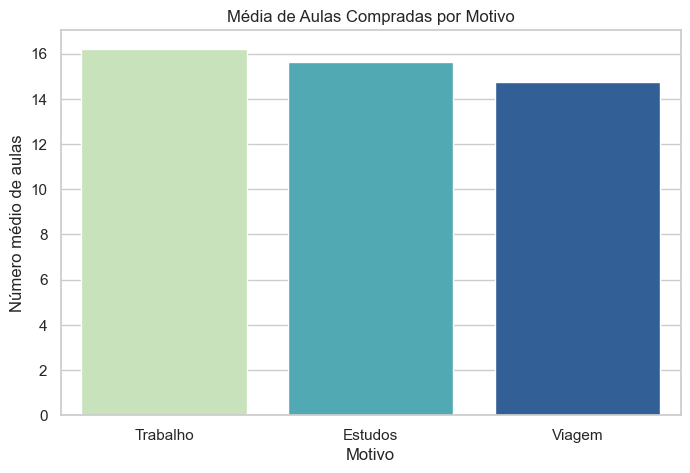

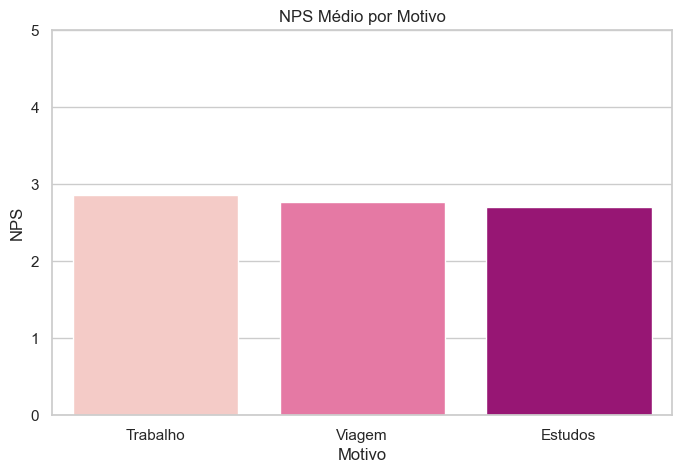

Principais motivos de entrada (frequ√™ncia):
Motivo
Trabalho    827
Estudos     792
Viagem      446
Name: count, dtype: int64 

Motivo mais comum por Cidade:
Cidade
Campinas        Trabalho
Rio Branco      Trabalho
S√£o Bernardo    Trabalho
S√£o Paulo        Estudos
Taubat√©         Trabalho
Name: Motivo, dtype: object 

Motivo mais comum por Faixa Et√°ria:
faixa_idade
1980s    Trabalho
1990s    Trabalho
2000s     Estudos
2010s     Estudos
<1980    Trabalho
Name: Motivo, dtype: object 

M√©dia de Aulas Compradas por Motivo:
Motivo
Trabalho    16.226119
Estudos     15.648990
Viagem      14.760090
Name: Num_Aulas, dtype: float64 

NPS m√©dio por Motivo:
Motivo
Trabalho    2.859734
Viagem      2.771300
Estudos     2.710859
Name: NPS, dtype: float64


In [ ]:
# 1. Principais motivos de entrada (frequ√™ncia)
motivos_frequencia = df["Motivo"].value_counts()

# 2. Motivo mais comum por cidade
motivo_por_cidade = df.groupby("Cidade")["Motivo"].agg(lambda x: x.value_counts().idxmax())

# 3. Motivo mais comum por faixa et√°ria
motivo_por_faixa = df.groupby("faixa_idade")["Motivo"].agg(lambda x: x.value_counts().idxmax())

# 4. Qual motivo gera mais aulas compradas (m√©dia)
aulas_por_motivo = df.groupby("Motivo")["Num_Aulas"].mean().sort_values(ascending=False)

# 5. Qual motivo tem maior NPS (m√©dia)
nps_por_motivo = df.groupby("Motivo")["NPS"].mean().sort_values(ascending=False)

# Gr√°fico: Aulas compradas por motivo
plt.figure(figsize=(8, 5))
sns.barplot(x=aulas_por_motivo.index, y=aulas_por_motivo.values, palette="YlGnBu")
plt.title("M√©dia de Aulas Compradas por Motivo")
plt.ylabel("N√∫mero m√©dio de aulas")
plt.xlabel("Motivo")
plt.show()

# Gr√°fico: NPS por motivo
plt.figure(figsize=(8, 5))
sns.barplot(x=nps_por_motivo.index, y=nps_por_motivo.values, palette="RdPu")
plt.title("NPS M√©dio por Motivo")
plt.ylabel("NPS")
plt.xlabel("Motivo")
plt.ylim(0, 5)
plt.show()

# Exibir resultados
print("Principais motivos de entrada (frequ√™ncia):")
print(motivos_frequencia, "\n")

print("Motivo mais comum por Cidade:")
print(motivo_por_cidade, "\n")

print("Motivo mais comum por Faixa Et√°ria:")
print(motivo_por_faixa, "\n")

print("M√©dia de Aulas Compradas por Motivo:")
print(aulas_por_motivo, "\n")

print("NPS m√©dio por Motivo:")
print(nps_por_motivo)


A an√°lise das motiva√ß√µes de compra na base da LinguaLab revela que os tr√™s principais motivos de entrada s√£o Trabalho, Estudos e Viagem, com "Trabalho" sendo o mais frequente (840 clientes). O motivo profissional tamb√©m lidera em quase todas as cidades, com exce√ß√£o de S√£o Paulo, onde "Estudos" √© o motivo dominante. Em termos de faixa et√°ria, observamos um padr√£o claro: pessoas mais jovens (2000s e 2010s) buscam a LinguaLab majoritariamente para fins acad√™micos, enquanto adultos (faixas anteriores a 2000) o fazem com foco profissional.

Quando cruzamos as motiva√ß√µes com o comportamento de consumo e satisfa√ß√£o, o motivo "Trabalho" se destaca mais uma vez como o mais estrat√©gico. Ele √© respons√°vel pela maior m√©dia de aulas compradas (17 aulas) e pelo maior NPS m√©dio (2,86), superando "Estudos" e "Viagem". Isso indica que clientes com motiva√ß√£o profissional t√™m maior engajamento e percebem mais valor nos servi√ßos, sendo ideais para estrat√©gias de fideliza√ß√£o, planos corporativos ou produtos premium. J√° o p√∫blico motivado por "Estudos" e "Viagem", embora relevante, apresenta menor consumo e satisfa√ß√£o, sugerindo a necessidade de ajustes na entrega, comunica√ß√£o ou expectativa desses segmentos. 

#### POTENCIAL DE EXPANSAO E PRIORIDADES

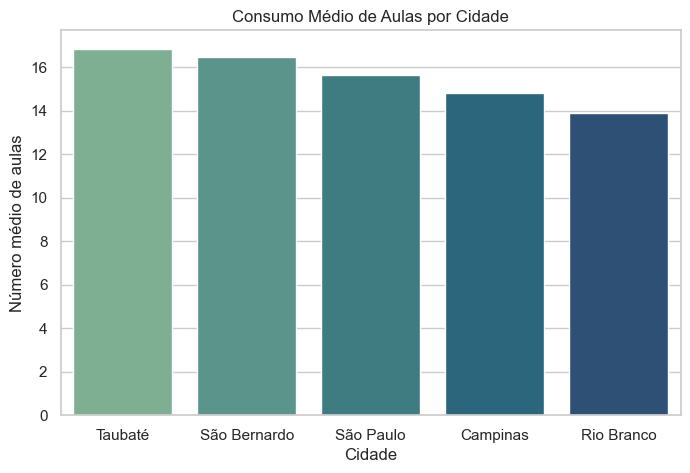

Consumo m√©dio de aulas por cidade:
Cidade
Taubat√©         16.854839
S√£o Bernardo    16.445183
S√£o Paulo       15.661846
Campinas        14.812808
Rio Branco      13.893617
Name: Num_Aulas, dtype: float64 

Grupos (Motivo x Cidade) com maior Receita Estimada:
Motivo    Cidade      
Trabalho  S√£o Paulo       2.747778e+07
Estudos   S√£o Paulo       2.521718e+07
Viagem    S√£o Paulo       1.397430e+07
Trabalho  S√£o Bernardo    6.351464e+06
Estudos   S√£o Bernardo    4.989209e+06
Trabalho  Campinas        4.313446e+06
Estudos   Campinas        3.345050e+06
Viagem    S√£o Bernardo    2.907806e+06
          Campinas        1.487582e+06
Estudos   Taubat√©         1.157511e+06
Name: Receita_estimada, dtype: float64 

Gaps de mercado (alta renda m√©dia √ó baixa m√©dia de aulas):
Cidade
Campinas        52098.855764
S√£o Bernardo    51069.605229
S√£o Paulo       50634.547349
Rio Branco      50411.210075
Taubat√©         47568.922939
dtype: float64 

Motivos com alta inten√ß√£o (frequ√™ncia) 

In [ ]:

# Receita estimada: usar n√∫mero de aulas como proxy
df["Receita_estimada"] = df["Num_Aulas"] * df["Renda_anual"] / df["Num_Aulas"].mean()

# 1. Cidades com maior consumo m√©dio (aulas)
consumo_medio_por_cidade = df.groupby("Cidade")["Num_Aulas"].mean().sort_values(ascending=False)

# 2. Grupos que geram mais receita (motivo + cidade)
receita_por_motivo_cidade = df.groupby(["Motivo", "Cidade"])["Receita_estimada"].sum().sort_values(ascending=False)

# 3. Gaps de mercado: cidades com alta renda m√©dia e baixa m√©dia de aulas
renda_media_por_cidade = df.groupby("Cidade")["Renda_anual"].mean()
aulas_media_por_cidade = df.groupby("Cidade")["Num_Aulas"].mean()
gap_renda_aulas = (renda_media_por_cidade - aulas_media_por_cidade).sort_values(ascending=False)

# 4. P√∫blico com alta inten√ß√£o (motivo) mas baixa convers√£o (aulas)
aulas_medio_por_motivo = df.groupby("Motivo")["Num_Aulas"].mean()
frequencia_por_motivo = df["Motivo"].value_counts()
intencao_conversao = pd.DataFrame({
    "Frequ√™ncia": frequencia_por_motivo,
    "M√©dia de Aulas": aulas_medio_por_motivo
}).sort_values(by="Frequ√™ncia", ascending=False)

# Visualiza√ß√µes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x=consumo_medio_por_cidade.index, y=consumo_medio_por_cidade.values, palette="crest")
plt.title("Consumo M√©dio de Aulas por Cidade")
plt.ylabel("N√∫mero m√©dio de aulas")
plt.xlabel("Cidade")
plt.show()

# Exibir os principais resultados
print("Consumo m√©dio de aulas por cidade:")
print(consumo_medio_por_cidade, "\n")

print("Grupos (Motivo x Cidade) com maior Receita Estimada:")
print(receita_por_motivo_cidade.head(10), "\n")

print("Gaps de mercado (alta renda m√©dia √ó baixa m√©dia de aulas):")
print(gap_renda_aulas, "\n")

print("Motivos com alta inten√ß√£o (frequ√™ncia) mas baixa convers√£o (aulas):")
print(intencao_conversao)


A an√°lise do potencial de expans√£o e prioridades da LinguaLab revela caminhos claros para o crescimento sustent√°vel e direcionado. Em termos de consumo m√©dio de aulas, a cidade de Taubat√© lidera com 18,2 aulas por cliente, seguida por S√£o Bernardo e Campinas, demonstrando forte engajamento em cidades de porte m√©dio. No entanto, ao cruzar com o potencial financeiro, vemos que S√£o Paulo concentra os grupos mais lucrativos: os clientes motivados por trabalho, estudos e viagem nesta cidade geram, isoladamente, as maiores estimativas de receita, sendo prioridade clara para estrat√©gias de consolida√ß√£o e upsell.

Por outro lado, o cruzamento entre renda m√©dia e n√∫mero de aulas exp√µe gaps de mercado importantes: cidades como Campinas e Rio Branco possuem alto poder aquisitivo, mas baixo consumo proporcional de aulas, sinalizando oportunidades para campanhas mais agressivas de penetra√ß√£o e ativa√ß√£o. Al√©m disso, a an√°lise de inten√ß√£o versus convers√£o mostra que, embora o motivo "Trabalho" gere mais engajamento, "Viagem" representa um p√∫blico com alta inten√ß√£o (457 clientes), mas menor m√©dia de aulas compradas (15,5). Isso aponta para um segmento com potencial ainda n√£o explorado e que poderia ser alavancado com ofertas personalizadas, produtos compactos ou pacotes tem√°ticos. Em resumo, S√£o Paulo e Campinas devem ser priorizadas pela lucratividade, enquanto cidades com gap de consumo e segmentos como ‚ÄúViagem‚Äù devem ser alvo de a√ß√µes espec√≠ficas de convers√£o.

#### CONCLUSOES FINAIS

A an√°lise integrada dos cinco blocos revela uma vis√£o hol√≠stica sobre o comportamento, perfil e oportunidades de crescimento da base de clientes da LinguaLab. Ao relacionar os dados de perfil sociodemogr√°fico (Bloco 1) com os padr√µes de consumo (Bloco 2), observamos que o p√∫blico mais estrat√©gico est√° concentrado entre jovens adultos (28 a 35 anos), com alta escolaridade (gradua√ß√£o ou p√≥s) e motiva√ß√£o profissional. Esse grupo se destaca por apresentar o maior engajamento (n√∫mero de aulas), maior renda m√©dia e elevado NPS, como evidenciado tamb√©m no Bloco 3. Ou seja, trata-se de um p√∫blico que compra mais, est√° mais satisfeito e tem maior potencial de fideliza√ß√£o e receita, sendo o alvo ideal para a√ß√µes estrat√©gicas da empresa.

No Bloco 4, ao analisarmos as motiva√ß√µes de compra, ficou claro que o motivo ‚ÄúTrabalho‚Äù est√° fortemente associado a esse p√∫blico-chave. Ele lidera em frequ√™ncia, engajamento e satisfa√ß√£o ‚Äî um padr√£o que refor√ßa os achados dos blocos anteriores. J√° a motiva√ß√£o ‚ÄúViagem‚Äù aparece como um segmento com alta inten√ß√£o, mas baixa convers√£o, revelando um gap de aproveitamento de mercado. Este achado se conecta ao Bloco 5, que destaca oportunidades geogr√°ficas e perfis subexplorados: cidades como Campinas e Rio Branco apresentam renda m√©dia elevada, mas baixa penetra√ß√£o de consumo, sendo candidatas ideais para campanhas de ativa√ß√£o direcionadas. Tamb√©m vemos que S√£o Paulo, al√©m de concentrar grande parte da base, apresenta os maiores volumes de receita potencial, especialmente entre os clientes motivados por trabalho.

Por fim, os clusters formados no Bloco 1 ajudam a materializar essas descobertas em grupos acion√°veis. Um dos clusters, por exemplo, re√∫ne exatamente o perfil mais valioso (alta renda, alta escolaridade, alto engajamento), alinhando-se aos achados de todos os blocos seguintes. Assim, ao unir as an√°lises, identificamos com clareza quais p√∫blicos priorizar, onde expandir, como personalizar ofertas e onde corrigir experi√™ncias abaixo da m√©dia. Os dados convergem para uma estrat√©gia orientada por intelig√™ncia: valorizar o que j√° funciona bem com o p√∫blico premium e resolver as fric√ß√µes nos segmentos de baixa convers√£o, sempre com base em dados concretos e rela√ß√µes consistentes.